In [11]:
from transformers import BertConfig
from gnn import GNNTrainer
from movie_lens_loader import MovieLensLoader
from llm import PromptBertClassifier, VanillaBertClassifier, AddingEmbeddingsBertClassifierBase

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader

In [5]:
config = BertConfig.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
KGE_DIMENSION_PROMPT = 4
KGE_DIMENSION_ADDING = 128
KGE_DIMENSIONS = [KGE_DIMENSION_PROMPT, KGE_DIMENSION_ADDING] # Output Dimension of the GNN Encoder.
model_max_length = 256
movie_lens_loader = MovieLensLoader(kge_dimensions = KGE_DIMENSIONS)
gnn_trainer_prompt =    GNNTrainer(movie_lens_loader.data, kge_dimension = KGE_DIMENSION_PROMPT)
gnn_trainer_prompt.get_embeddings(movie_lens_loader)
gnn_trainer_adding =    GNNTrainer(movie_lens_loader.data, hidden_channels=KGE_DIMENSION_ADDING, kge_dimension = KGE_DIMENSION_ADDING)
gnn_trainer_adding.get_embeddings(movie_lens_loader)
vanilla_bert_only_classifier = VanillaBertClassifier(movie_lens_loader.llm_df,model_max_length = model_max_length)
dataset_vanilla = movie_lens_loader.generate_vanilla_dataset(vanilla_bert_only_classifier.tokenize_function)
prompt_bert_only_classifier = PromptBertClassifier(movie_lens_loader, gnn_trainer_prompt.get_embedding, kge_dimension=gnn_trainer_prompt.kge_dimension, batch_size=64,model_max_length = model_max_length)
dataset_prompt = movie_lens_loader.generate_prompt_embedding_dataset(prompt_bert_only_classifier.tokenize_function, kge_dimension = prompt_bert_only_classifier.kge_dimension)
adding_embedding_bert_only_classifier = AddingEmbeddingsBertClassifierBase(movie_lens_loader, gnn_trainer_adding.get_embedding, kge_dimension=config.hidden_size, batch_size=64,model_max_length = model_max_length)
dataset_adding_embedding = movie_lens_loader.generate_adding_embedding_dataset(adding_embedding_bert_only_classifier.tokenizer.sep_token, adding_embedding_bert_only_classifier.tokenizer.pad_token, adding_embedding_bert_only_classifier.tokenize_function, kge_dimension = config.hidden_size)

loading pretrained model
Device: 'cpu'
loading pretrained model
Device: 'cpu'
---./data/llm/128/adding_dataset


# Current State
Here I want to plot the attentions not only between single tokens but between the embedding part and non-embedding part.

In [13]:
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind
ALL_LABEL_FAMILIES = ["user_id", "movie_id", "title", "genres"]
PROMPT_LABEL_FAMILIES = ALL_LABEL_FAMILIES + ["user embedding", "movie embedding"]

In [14]:

def vanilla_attention_weights(self: PromptBertClassifier, dataset, batch_size = 64, layer = -1):
    self.model.eval()
    all_result_matrix = []
    with torch.no_grad():
        for _ in range(3):
            data_loader = DataLoader(dataset=dataset, batch_size= batch_size, collate_fn = self.data_collator)
            for batch in data_loader:
                outputs = self.model(input_ids = batch["input_ids"], attention_mask = batch["attention_mask"], output_attentions=True)
                attentions = outputs.attentions  # This will contain the attention weights for each layer and head
                combined_attention = torch.sum(attentions[layer], dim=1).squeeze().detach().numpy()
                tokens = self.tokenizer.convert_ids_to_tokens(batch['input_ids'][0])
                starting_index_user_id = find_sub_list(['user', ':'], tokens)
                starting_index_title = find_sub_list(['title', ':'], tokens)
                starting_index_genres = find_sub_list(['genres', ':'], tokens)
                ending_index = find_sub_list(['[SEP]', '[PAD]', '[PAD]'], tokens)
                ranges = [
                    (starting_index_user_id,starting_index_title-1),
                    (starting_index_title,starting_index_genres-1),
                    (starting_index_genres,ending_index),
                ]
                result_matrix = np.zeros((len(ALL_LABEL_FAMILIES), len(ALL_LABEL_FAMILIES)))
                for i, (start_index_i, end_index_i) in enumerate(ranges):
                    for j, (start_index_j, end_index_j) in enumerate(ranges):
                        submatrix = combined_attention[start_index_i:end_index_i, start_index_j:end_index_j]
                        result_matrix[i, j] = np.sum(submatrix)
            all_result_matrix.append(result_matrix)

    # Stack the arrays along a new axis
    stacked_matrix = np.stack(all_result_matrix, axis=0)
    # Compute the mean along the first axis
    mean_matrix = np.mean(stacked_matrix, axis=0)
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(mean_matrix, xticklabels=ALL_LABEL_FAMILIES, yticklabels=ALL_LABEL_FAMILIES, cmap='viridis', ax=ax)
    plt.title('Combined Attention Weights for Layer 1 After Linear Projectionof Vanilla Classifier')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

In [15]:

def prompt_attention_weights(self: PromptBertClassifier, dataset, split = "test", batch_size = 64, layer = -1):
    self.model.eval()
    data_collator = self.test_data_collator if split == "test" else self.eval_data_collator if split == "val" else self.train_data_collator
    all_result_matrix = []
    with torch.no_grad():
        for _ in range(3):
            data_loader = DataLoader(dataset=dataset[split], batch_size= batch_size, collate_fn = data_collator)
            for batch in data_loader:
                outputs = self.model(input_ids = batch["input_ids"], attention_mask = batch["attention_mask"], output_attentions=True)
                attentions = outputs.attentions  # This will contain the attention weights for each layer and head
                combined_attention = torch.sum(attentions[layer], dim=1).squeeze().detach().numpy()
                tokens = self.tokenizer.convert_ids_to_tokens(batch['input_ids'][0])
                starting_index_user_id = find_sub_list(['user', ':'], tokens)
                starting_index_title = find_sub_list(['title', ':'], tokens)
                starting_index_genres = find_sub_list(['genres', ':'], tokens)
                starting_index_user_embeddings = find_sub_list(['user', 'em', '##bed', '##ding', ':', '['], tokens)
                starting_index_movie_embeddings = find_sub_list(['movie', 'em', '##bed', '##ding', ':', '['], tokens)
                ending_index_movie_embeddings = find_sub_list([']', '[SEP]', '[PAD]', '[PAD]'], tokens)
                ranges = [
                    (starting_index_user_id,starting_index_title-1),
                    (starting_index_title,starting_index_genres-1),
                    (starting_index_genres,starting_index_user_embeddings),
                    (starting_index_user_embeddings,starting_index_movie_embeddings-2),
                    (starting_index_movie_embeddings,ending_index_movie_embeddings)
                ]
                result_matrix = np.zeros((len(PROMPT_LABEL_FAMILIES), len(PROMPT_LABEL_FAMILIES)))
                for i, (start_index_i, end_index_i) in enumerate(ranges):
                    for j, (start_index_j, end_index_j) in enumerate(ranges):
                        submatrix = combined_attention[start_index_i:end_index_i, start_index_j:end_index_j]
                        result_matrix[i, j] = np.sum(submatrix)
                all_result_matrix.append(result_matrix)
    # Stack the arrays along a new axis
    stacked_matrix = np.stack(all_result_matrix, axis=0)
    # Compute the mean along the first axis
    mean_matrix = np.mean(stacked_matrix, axis=0)
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(mean_matrix, xticklabels=PROMPT_LABEL_FAMILIES, yticklabels=PROMPT_LABEL_FAMILIES, cmap='viridis', ax=ax)
    plt.title('Combined Attention Weights for Layer 1 After Linear Projection of Prompt Classifier')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

In [26]:

def adding_embedding_attention_weights(self: AddingEmbeddingsBertClassifierBase, dataset, split = "test", batch_size = 64, layer = -1):
    self.model.eval()
    data_collator = self.test_data_collator if split == "test" else self.eval_data_collator if split == "val" else self.train_data_collator
    all_result_matrix = []
    with torch.no_grad():
        for _ in range(3):
            data_loader = DataLoader(dataset=dataset[split], batch_size= batch_size, collate_fn = data_collator)
            for batch in data_loader:
                outputs = model(input_ids = batch["input_ids"], attention_mask = batch["attention_mask"], graph_embeddings = batch["graph_embeddings"], output_attentions=True)
                attentions = outputs.attentions  # This will contain the attention weights for each layer and head
                combined_attention = torch.sum(attentions[layer], dim=1).squeeze().detach().numpy()
                tokens = tokenizer.convert_ids_to_tokens(batch['input_ids'][0])
                starting_index_user_id = find_sub_list(['user', ':'], tokens)
                starting_index_title = find_sub_list(['title', ':'], tokens)
                starting_index_genres = find_sub_list(['genres', ':'], tokens)
                starting_index_sep_embeddings = find_sub_list(['[SEP]','[PAD]','[SEP]','[PAD]','[SEP]'], tokens)
                ranges = [
                    (starting_index_user_id,starting_index_title-1),
                    (starting_index_title,starting_index_genres-1),
                    (starting_index_genres,starting_index_sep_embeddings),
                    (starting_index_sep_embeddings+1,starting_index_sep_embeddings+2),
                    (starting_index_sep_embeddings+3,starting_index_sep_embeddings+4)
                ]
                result_matrix = np.zeros((len(PROMPT_LABEL_FAMILIES), len(PROMPT_LABEL_FAMILIES)))
                for i, (start_index_i, end_index_i) in enumerate(ranges):
                    for j, (start_index_j, end_index_j) in enumerate(ranges):
                        submatrix = combined_attention[start_index_i:end_index_i, start_index_j:end_index_j]
                        result_matrix[i, j] = np.sum(submatrix)
                all_result_matrix.append(result_matrix)
            # Stack the arrays along a new axis
            stacked_matrix = np.stack(all_result_matrix, axis=0)
            # Compute the mean along the first axis
            mean_matrix = np.mean(stacked_matrix, axis=0)
            fig, ax = plt.subplots(figsize=(5, 5))
            sns.heatmap(mean_matrix, xticklabels=PROMPT_LABEL_FAMILIES, yticklabels=PROMPT_LABEL_FAMILIES, cmap='viridis', ax=ax)
            plt.title('Combined Attention Weights for Layer 1 After Linear Projection of Adding Embedding Classifier')
            plt.xlabel('Tokens')
            plt.ylabel('Tokens')
            plt.show()

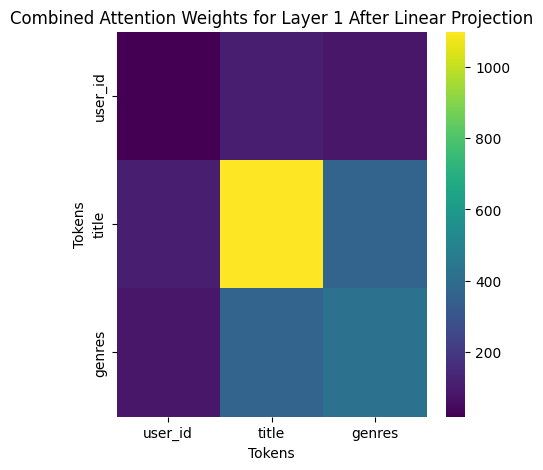

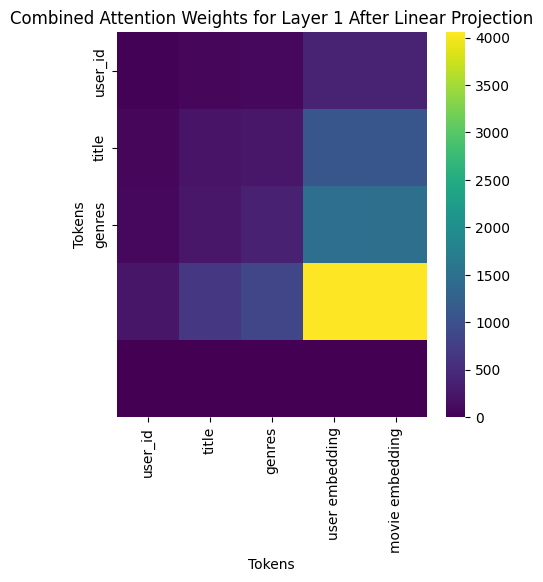

In [32]:
vanilla_attention_weights(vanilla_bert_only_classifier, dataset_vanilla["test"])
prompt_attention_weights(prompt_bert_only_classifier, dataset_prompt)
adding_embedding_attention_weights(adding_embedding_bert_only_classifier, dataset_prompt)

In [22]:
datapoint = dataset_adding_embedding["train"][0]
adding_embedding_bert_only_classifier.tokenizer.convert_ids_to_tokens(datapoint['input_ids'])

['[CLS]',
 'user',
 ':',
 '0',
 ',',
 'title',
 ':',
 'toy',
 'story',
 '(',
 '1995',
 ')',
 ',',
 'genres',
 ':',
 '[',
 "'",
 'adventure',
 "'",
 ',',
 "'",
 'animation',
 "'",
 ',',
 "'",
 'children',
 "'",
 ',',
 "'",
 'comedy',
 "'",
 ',',
 "'",
 'fantasy',
 "'",
 ']',
 '[SEP]',
 '[PAD]',
 '[SEP]',
 '[PAD]',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PA

In [55]:
keywords = [":", "user", "title", "genres", "[SEP]", "[PAD]"]
keywords_id_dict = dict()
tokenizer = adding_embedding_bert_only_classifier.tokenizer
for keyword in keywords:
    keywords_id_dict[keyword] = tokenizer(keyword)["input_ids"][1:-1]
print(keywords_id_dict)

def get_ids_for_keyword_list(keyword_list):
    keyword_ids = []
    for keyword in keyword_list:
        keyword_ids.extend(keywords_id_dict[keyword])
    return torch.tensor(keyword_ids)

{':': [1024], 'user': [5310], 'title': [2516], 'genres': [11541], '[SEP]': [102], '[PAD]': [0]}


In [80]:
def _find_sub_tensor(subtensor, t):
    print(subtensor.shape)
    print(subtensor)
    zeros = torch.zeros_like(t)
    zeros[:,:len(subtensor)] = subtensor
    print("s", zeros.shape)
    mask = torch.where(t == zeros, 1.0, t)
    print(mask[0])
data_loader = DataLoader(dataset=dataset_adding_embedding["test"], batch_size= 64, collate_fn = adding_embedding_bert_only_classifier.train_data_collator)
model = adding_embedding_bert_only_classifier.model
tokenizer = adding_embedding_bert_only_classifier.tokenizer
layer = -1
user_sublist = get_ids_for_keyword_list(['user', ':'])
title_sublist = get_ids_for_keyword_list(['title', ':'])
genres_sublist = get_ids_for_keyword_list(['genres', ':'])
sep_sublist = get_ids_for_keyword_list(['[SEP]','[PAD]','[SEP]','[PAD]','[SEP]'])
all_result_matrix = []
batch =next(iter(data_loader))
outputs = model(input_ids = batch["input_ids"], attention_mask = batch["attention_mask"], graph_embeddings = batch["graph_embeddings"], output_attentions=True)
attentions = outputs.attentions  # This will contain the attention weights for each layer and head
combined_attention = torch.sum(attentions[layer], dim=1).squeeze().detach().numpy()
print(combined_attention.shape)
print(batch["input_ids"].shape)
starting_index_user_id = _find_sub_tensor(user_sublist, batch["input_ids"])
starting_index_title = find_sub_list(title_sublist, batch["input_ids"])
starting_index_genres = find_sub_list(genres_sublist, batch["input_ids"])
starting_index_sep_embeddings = find_sub_list(sep_sublist, batch["input_ids"])
ranges = [
    (starting_index_user_id,starting_index_title-1),
    (starting_index_title,starting_index_genres-1),
    (starting_index_genres,starting_index_sep_embeddings),
    (starting_index_sep_embeddings+1,starting_index_sep_embeddings+2),
    (starting_index_sep_embeddings+3,starting_index_sep_embeddings+4)
]
result_matrix = np.zeros((len(PROMPT_LABEL_FAMILIES), len(PROMPT_LABEL_FAMILIES)))
for i, (start_index_i, end_index_i) in enumerate(ranges):
    for j, (start_index_j, end_index_j) in enumerate(ranges):
        submatrix = combined_attention[start_index_i:end_index_i, start_index_j:end_index_j]
        result_matrix[i, j] = np.sum(submatrix)
all_result_matrix.append(result_matrix)
# Stack the arrays along a new axis
stacked_matrix = np.stack(all_result_matrix, axis=0)
# Compute the mean along the first axis
mean_matrix = np.mean(stacked_matrix, axis=0)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(mean_matrix, xticklabels=PROMPT_LABEL_FAMILIES, yticklabels=PROMPT_LABEL_FAMILIES, cmap='viridis', ax=ax)
plt.title('Combined Attention Weights for Layer 1 After Linear Projection of Adding Embedding Classifier')
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.show()
    

(64, 512, 512)
torch.Size([64, 512])
torch.Size([2])
tensor([5310, 1024])
s torch.Size([64, 512])
tensor([ 1.0100e+02,  5.3100e+03,  1.0240e+03,  1.7273e+04,  1.0100e+03,
         2.5160e+03,  1.0240e+03,  2.5290e+03,  3.2670e+03,  1.0060e+03,
         2.5410e+03,  1.0070e+03,  1.0100e+03,  1.1541e+04,  1.0240e+03,
         1.0310e+03,  1.0050e+03,  4.0380e+03,  1.0050e+03,  1.0100e+03,
         1.0050e+03,  7.4720e+03,  1.0050e+03,  1.0330e+03,  1.0200e+02,
        -1.0000e+00,  1.0200e+02, -1.0000e+00,  1.0200e+02, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.00

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [66]:
tensor = torch.tensor([1,2,3])
tensor.repeat((2,1))

tensor([[1, 2, 3],
        [1, 2, 3]])

In [33]:

def prompt_attention_weights(self: PromptBertClassifier, dataset, split = "test", batch_size = 64, layer = -1):
    self.model.eval()
    data_collator = self.test_data_collator if split == "test" else self.eval_data_collator if split == "val" else self.train_data_collator
    all_result_matrix = []
    with torch.no_grad():
        for _ in range(3):
            data_loader = DataLoader(dataset=dataset[split], batch_size= batch_size, collate_fn = data_collator)
            for batch in data_loader:
                outputs = self.model(input_ids = batch["input_ids"], attention_mask = batch["attention_mask"], output_attentions=True)
                attentions = outputs.attentions  # This will contain the attention weights for each layer and head
                combined_attention = torch.sum(attentions[layer], dim=1).squeeze().detach().numpy()
                tokens = self.tokenizer.convert_ids_to_tokens(batch['input_ids'][0])
                starting_index_user_id = find_sub_list(['user', ':'], tokens)
                starting_index_title = find_sub_list(['title', ':'], tokens)
                starting_index_genres = find_sub_list(['genres', ':'], tokens)
                starting_index_user_embeddings = find_sub_list(['user', 'em', '##bed', '##ding', ':', '['], tokens)
                starting_index_movie_embeddings = find_sub_list(['movie', 'em', '##bed', '##ding', ':', '['], tokens)
                ending_index_movie_embeddings = find_sub_list([']', '[SEP]', '[PAD]', '[PAD]'], tokens)
                ranges = [
                    (starting_index_user_id,starting_index_title-1),
                    (starting_index_title,starting_index_genres-1),
                    (starting_index_genres,starting_index_user_embeddings),
                    (starting_index_user_embeddings,starting_index_movie_embeddings-2),
                    (starting_index_movie_embeddings,ending_index_movie_embeddings)
                ]
                result_matrix = np.zeros((len(PROMPT_LABEL_FAMILIES), len(PROMPT_LABEL_FAMILIES)))
                for i, (start_index_i, end_index_i) in enumerate(ranges):
                    for j, (start_index_j, end_index_j) in enumerate(ranges):
                        submatrix = combined_attention[start_index_i:end_index_i, start_index_j:end_index_j]
                        result_matrix[i, j] = np.sum(submatrix)
                all_result_matrix.append(result_matrix)
    # Stack the arrays along a new axis
    stacked_matrix = np.stack(all_result_matrix, axis=0)
    # Compute the mean along the first axis
    mean_matrix = np.mean(stacked_matrix, axis=0)
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(mean_matrix, xticklabels=PROMPT_LABEL_FAMILIES, yticklabels=ALL_LABEL_FAMILIES, cmap='viridis', ax=ax)
    plt.title('Combined Attention Weights for Layer 1 After Linear Projection')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

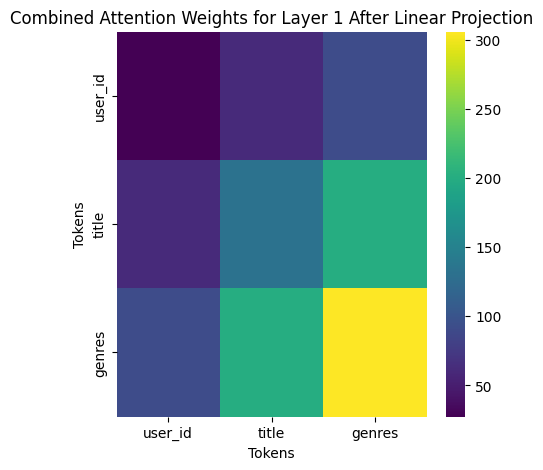

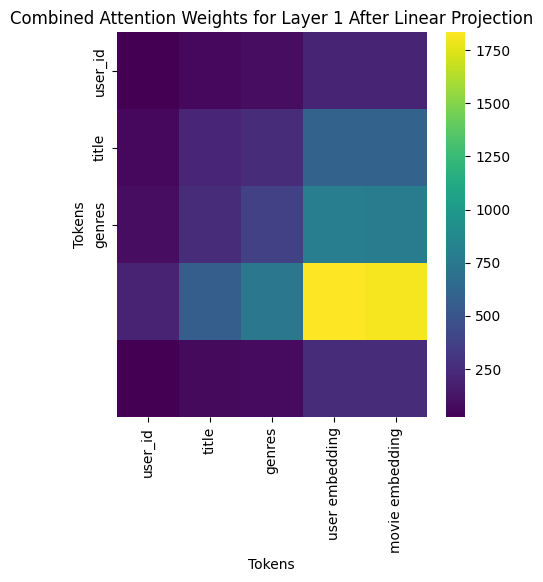

In [34]:
vanilla_attention_weights(vanilla_bert_only_classifier, dataset_vanilla["test"])
prompt_attention_weights(prompt_bert_only_classifier, dataset_prompt)

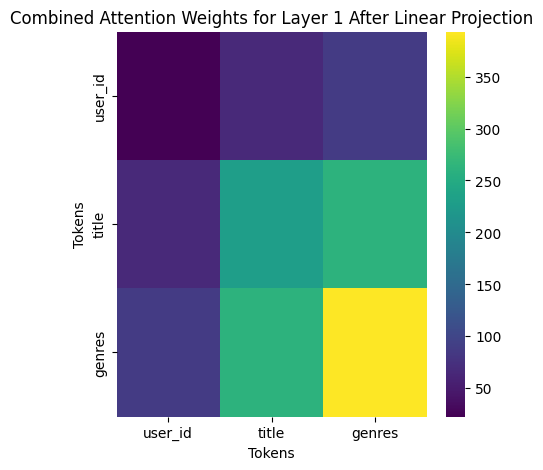

In [21]:
data_loader = DataLoader(dataset=dataset_vanilla["test"], batch_size= 64, collate_fn = vanilla_bert_only_classifier.data_collator)
model = vanilla_bert_only_classifier.model
tokenizer = vanilla_bert_only_classifier.tokenizer
layer = -1
all_result_matrix = []
for batch in data_loader:
    model.eval()
    with torch.no_grad():
        attentions = model(input_ids = batch["input_ids"], attention_mask = batch["attention_mask"], output_attentions=True).attentions
        combined_attention = torch.sum(attentions[layer], dim=1).squeeze().detach().numpy()
        tokens = tokenizer.convert_ids_to_tokens(batch['input_ids'][0])
        starting_index_user_id = find_sub_list(['user', ':'], tokens)
        starting_index_title = find_sub_list(['title', ':'], tokens)
        starting_index_genres = find_sub_list(['genres', ':'], tokens)
        ending_index = find_sub_list(['[SEP]', '[PAD]', '[PAD]'], tokens)
        ranges = [
            (starting_index_user_id,starting_index_title-1),
            (starting_index_title,starting_index_genres-1),
            (starting_index_genres,ending_index),
        ]
        result_matrix = np.zeros((len(ALL_LABEL_FAMILIES), len(ALL_LABEL_FAMILIES)))
        for i, (start_index_i, end_index_i) in enumerate(ranges):
            for j, (start_index_j, end_index_j) in enumerate(ranges):
                submatrix = combined_attention[start_index_i:end_index_i, start_index_j:end_index_j]
                result_matrix[i, j] = np.sum(submatrix)
    all_result_matrix.append(result_matrix)

# Stack the arrays along a new axis
stacked_matrix = np.stack(all_result_matrix, axis=0)
# Compute the mean along the first axis
mean_matrix = np.mean(stacked_matrix, axis=0)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(mean_matrix, xticklabels=ALL_LABEL_FAMILIES, yticklabels=ALL_LABEL_FAMILIES, cmap='viridis', ax=ax)
plt.title('Combined Attention Weights for Layer 1 After Linear Projection')
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.show()